In [275]:
import os
import glob
import pandas as pd
import numpy as np

In [2]:
%ls

Classification.ipynb     cats_vs_dogs.ipynb       test1.zip
HandRight.csv            fashion-mnist_test.csv   train/
HandsSync.ipynb          fashion-mnist_train.csv  train.zip
HandsTraining/           fmnist.ipynb             winequality-red.csv
HandsValidation/         sampleSubmission.csv
README.md                test1/


# Are the Hands in sync ?

<div>
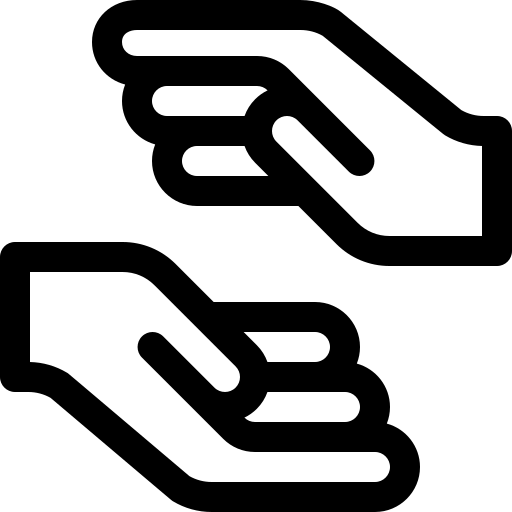
</div>


Hey, this notebook is about checking whether we can predict if the person is moving their hands spotanously in sync with someone or alone

The instruction that were given for the data pre processing:

1. in the directories with duplicate files delete the files that appear first
2. load the righthand data and merge it with each `alone` dataset 
3. creates labels and try to predict the state of the hands

In [3]:
rightHandData = pd.read_csv('./HandRight.csv')


rightHandData.columns = rightHandData.columns.str.strip()

rightHandData

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.671670,226.2064,20.264700,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.241190,222.9389,20.117810,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.724610,220.9709,19.949720,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.090160,219.7124,19.676790,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.460170,219.3652,19.131280,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,208.1942,24687,right,1,-15.404800,208.0276,9.980799,167.86240,510.085200,-105.529500,...,-0.282299,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.503490,0.0
4808,208.2108,24689,right,1,-12.678650,218.1196,9.314082,145.00970,562.359400,-20.707010,...,-0.263492,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.403687,0.0
4809,208.2276,24691,right,1,-9.643562,228.2807,9.722980,180.42160,591.901900,28.880570,...,-0.234336,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.310940,0.0
4810,208.2443,24692,right,1,-7.980715,233.5056,10.419080,192.45930,604.734400,80.566980,...,-0.222084,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.286526,0.0


In [4]:
firsrtTimestamp = rightHandData.head(1)["Time"][0]

rightHandData = rightHandData.drop(rightHandData[rightHandData.Time < firsrtTimestamp+7].index)

In [194]:
rightHandData.drop(rightHandData[rightHandData["Hand Type"]=='left'].index, inplace=True)
rightHandData.drop(['# hands'], axis=1, inplace=True)

In [195]:
rightHandData

,Time,Frame ID,Hand Type,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
421,135.3024,16287,right,11.930320,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
422,135.3194,16289,right,11.191900,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
423,135.3357,16291,right,10.533080,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
424,135.3524,16293,right,10.243000,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
425,135.3690,16295,right,10.020610,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,208.1942,24687,right,-15.404800,208.0276,9.980799,167.862400,510.0852,-105.52950,0.235165,...,-0.282299,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.503490,0.0
4808,208.2108,24689,right,-12.678650,218.1196,9.314082,145.009700,562.3594,-20.70701,0.309213,...,-0.263492,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.403687,0.0
4809,208.2276,24691,right,-9.643562,228.2807,9.722980,180.421600,591.9019,28.88057,0.369046,...,-0.234336,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.310940,0.0
4810,208.2443,24692,right,-7.980715,233.5056,10.419080,192.459300,604.7344,80.56698,0.381206,...,-0.222084,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.286526,0.0


## The label of each type is as follows:

alone: 0

sync: 1

spontan: 2

In [229]:
def prep_alone_data(df):
    right_hand_copy = pd.DataFrame.copy(rightHandData)
    
    right_hand_copy = right_hand_copy.reset_index(drop=True)
    
    df.drop(df[df["Hand Type"]=='right'].index, inplace=True)
    df = df.reset_index(drop=True)
    
    right_hand_copy = right_hand_copy.truncate(after=df.index.size-1)
    
    right_hand_copy["Frame ID"] = df["Frame ID"]
    right_hand_copy["Time"] = df["Time"]
    
    zab = right_hand_copy.append(df)
    
    
    return zab

In [230]:
babi = []
for filename in glob.iglob('./HandsTraining/**/*.csv', recursive=True):
    
    cleansed_name = filename.split('/')[-1].split('.')[0].lower()
    
    data = pd.read_csv(filename)
    firsrtTimestamp = data.head(1)["Time"][0]
    data = data.drop(data[data.Time < firsrtTimestamp+7].index)
    data.columns = data.columns.str.strip()
    data.drop(['# hands'], axis=1, inplace=True)
    
    if 'alone' in cleansed_name:
        data = prep_alone_data(data)
        data['type'] = 0
    
    if 'sync' in cleansed_name:
        data['type'] = 1
    
    if 'spontan' in cleansed_name:
        data['type'] = 2

    babi.append(data) 

0
4
6
11
14
15
19
21
24


In [270]:
babi[14]["Hand Type"].value_counts()

left     4104
right    4104
Name: Hand Type, dtype: int64

In [235]:
to_clear = {'Frame ID', 'type'}

def clear_columns(df):
    for column_name in df:
        column_prefix = column_name.split('_')[0]
        if column_prefix in to_clear:
            df[column_prefix] = df[column_name]
            df.drop([column_name], axis=1, inplace=True)

In [309]:
cleansed_data = []

for data in babi:
    data["Time"]= data["Time"].round(1)
    temp_df = data.groupby(["Time","Hand Type"]).mean().unstack()
    temp_df.columns = [f"{x}_{y}" for x, y in temp_df.columns.to_flat_index()]
    clear_columns(temp_df)
    temp_df = temp_df.reset_index(drop=True)
    cleansed_data.append(temp_df)



In [310]:
cleansed_data[3]

,Position X_left,Position X_right,Position Y_left,Position Y_right,Position Z_left,Position Z_right,Velocity X_left,Velocity X_right,Velocity Y_left,Velocity Y_right,...,Elbow Pos Z_left,Elbow Pos Z_right,Grab Strenth_left,Grab Strenth_right,Grab Angle_left,Grab Angle_right,Pinch Strength_left,Pinch Strength_right,Frame ID,type
0,-104.176067,151.850833,202.425900,204.219833,-2.174457,-38.827963,-159.954133,-32.245633,351.843333,-18.329017,...,6.043082,161.981133,0.000000,1.000000,1.862598,2.639915,0.000000,0.266489,129365.333333,2.0
1,-111.096017,152.051500,224.557917,202.831233,-5.156290,-38.099292,-70.394892,-12.796293,276.056433,-13.527625,...,-25.737406,157.194033,0.152919,0.646507,1.908758,1.663440,0.000000,0.008796,129374.000000,2.0
2,-114.078217,147.568917,252.931933,196.753183,-13.231878,-41.829492,-1.134030,-30.630195,260.640867,-87.289018,...,-47.701295,144.501700,0.156509,0.153252,1.441555,1.085794,0.000000,0.000000,129385.666667,2.0
3,-113.187733,148.013433,272.007650,190.260783,-23.877158,-39.709773,7.996151,17.365098,143.945940,-54.156960,...,-59.332285,185.991883,0.000000,0.191391,0.933028,1.206966,0.000000,0.000000,129397.000000,2.0
4,-114.573467,149.445517,276.722683,185.161883,-38.454785,-35.756335,-37.645545,8.645290,-39.855830,-29.666379,...,-55.697182,202.478950,0.000000,0.094254,0.866536,1.071835,0.000000,0.000000,129408.666667,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,-89.039510,157.130950,131.278717,296.831667,25.970957,-12.064045,44.918160,-16.976448,41.970055,380.888350,...,28.921845,90.447382,0.136867,0.000000,1.301041,1.285598,0.015031,0.756990,137154.000000,2.0
677,-89.229948,154.127350,145.045300,325.305450,18.614668,-10.217536,-30.693507,-28.203527,201.371883,181.295527,...,17.934017,68.902478,0.000000,0.000000,0.602954,1.338841,0.036320,0.705975,137165.000000,2.0
678,-90.402435,154.607350,165.097617,320.116500,19.993168,-12.019692,1.340516,27.369260,189.165200,-241.069467,...,21.672037,67.403295,0.000000,0.000000,0.247269,1.010186,0.000000,0.602730,137177.000000,2.0
679,-94.286843,156.185667,184.560200,281.708800,27.076143,-22.005660,-63.607283,25.204846,193.583033,-470.437483,...,26.452890,103.649187,0.000000,0.000000,0.388205,0.259047,0.000000,0.000000,137188.000000,2.0


In [286]:
cleansed_data[1][cleansed_data[1]["type"]==np.nan]

,Position X_left,Position X_right,Position Y_left,Position Y_right,Position Z_left,Position Z_right,Velocity X_left,Velocity X_right,Velocity Y_left,Velocity Y_right,...,Elbow Pos Z_left,Elbow Pos Z_right,Grab Strenth_left,Grab Strenth_right,Grab Angle_left,Grab Angle_right,Pinch Strength_left,Pinch Strength_right,Frame ID,type
Time,,,,,,,,,,,,,,,,,,,,,
